In [1]:
#pip install pandas
#!pip install umap-learn
#!pip install scanpy
#!pip install 'umap-learn==0.3.10'
#!pip install "anndata==0.8.0rc1"
#!pip install git+https://github.com/theislab/scanpy.git@1.7.0rc1

In [2]:
#pip install git+https://github.com/theislab/scanpy.git@1.7.0rc1

In [1]:
import numpy as np
from typing import Tuple
from scipy.optimize import linear_sum_assignment
from numba import njit
from scipy.sparse.linalg import lobpcg
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import seaborn as sns
import sys
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import loompy
import velocyto as vcy
from sklearn.svm import SVR
import pickle
import scipy.sparse as ss
import math
from sklearn.neighbors import NearestNeighbors
from numpy import savetxt
from typing import Dict
import anndata as ad
from sklearn.svm import SVR

In [2]:
from threadpoolctl import threadpool_limits
threadpool_limits(limits=6)


In [5]:
sc.settings.verbosity = 1             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(3, 3), facecolor='white')


# Load PBMC_3X_10XMultiome

In [6]:
sc.settings.set_figure_params(dpi=120)
sns.set_style("dark")


In [7]:


def filter_cv_vs_mean(S: np.ndarray, N: int, svr_gamma: float=None, plot: bool=True, min_expr_cells: int=2,
                      max_expr_avg: float=20, min_expr_avg: float=0) -> np.ndarray:
    muS = S.mean(1)
    detected_bool = ((S > 0).sum(1) > min_expr_cells) & (muS < max_expr_avg) & (muS > min_expr_avg)
    
    Sf = S[detected_bool, :]
    mu = Sf.mean(1)
    sigma = Sf.std(1, ddof=1)

    cv = sigma / mu
    log_m = np.log2(mu)
    log_cv = np.log2(cv)
    
    if svr_gamma is None:
        svr_gamma = 150. / len(mu)
    
    svr = SVR(gamma=svr_gamma)
    svr.fit(log_m[:, None], log_cv)
    fitted_fun = svr.predict
    ff = fitted_fun(log_m[:, None])
    score = log_cv - ff

    xnew = np.linspace(np.min(log_m), np.max(log_m))
    ynew = svr.predict(xnew[:, None])

    nth_score = np.sort(score)[::-1][N]
    
    if plot:
        plt.scatter(log_m[score > nth_score], log_cv[score > nth_score], s=3, alpha=0.4, c="tab:red")
        plt.scatter(log_m[score <= nth_score], log_cv[score <= nth_score], s=3, alpha=0.4, c="tab:blue")
        mu_linspace = np.linspace(np.min(log_m), np.max(log_m))
        plt.plot(mu_linspace, fitted_fun(mu_linspace[:, None]), c="k")
        plt.xlabel("log2 mean S")
        plt.ylabel("log2 CV S")
    
    cv_mean_score = np.zeros(detected_bool.shape)
    cv_mean_score[~detected_bool] = np.min(score) - 1e-16
    cv_mean_score[detected_bool] = score
    cv_mean_selected = cv_mean_score >= nth_score
    return cv_mean_selected


In [8]:
adata = sc.read_h5ad("PBMC_3K_10XMultiome_AnnotatedV1.h5ad")
adata

AnnData object with n_obs × n_vars = 2885 × 36601
    obs: 'n_counts', 'n_genes', 'percent_mito', 'cell_type'
    var: 'feature_types', 'gene_ids'
    uns: 'cell_type_colors', 'mode2_var_chr', 'mode2_var_end', 'mode2_var_start', 'release', 'species'
    obsm: 'X_umap', 'mode2'

**RNA**

In [9]:
adata.obs['n_counts'] = adata.X.sum(axis=1)
print(np.mean(adata.obs['n_counts']))
print(np.std(adata.obs['n_counts'])), 
print(2.5*int(np.std(adata.obs['n_counts'])) + int(np.mean(adata.obs['n_counts'])))


3213.091552734375
1465.6004638671875
6875.5


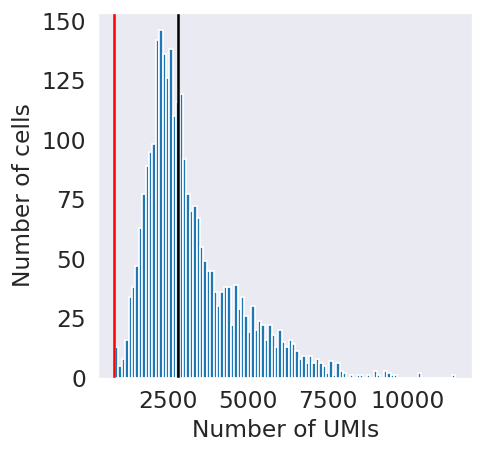

In [10]:
n, bins, *x = plt.hist(adata.obs['n_counts'], bins=100)
plt.xlabel("Number of UMIs")
plt.ylabel("Number of cells")
plt.axvline(np.median(adata.obs['n_counts']), c="black")
plt.axvline(800, c="r")
plt.show()


In [11]:
sc.pp.filter_cells(adata, min_counts=800)


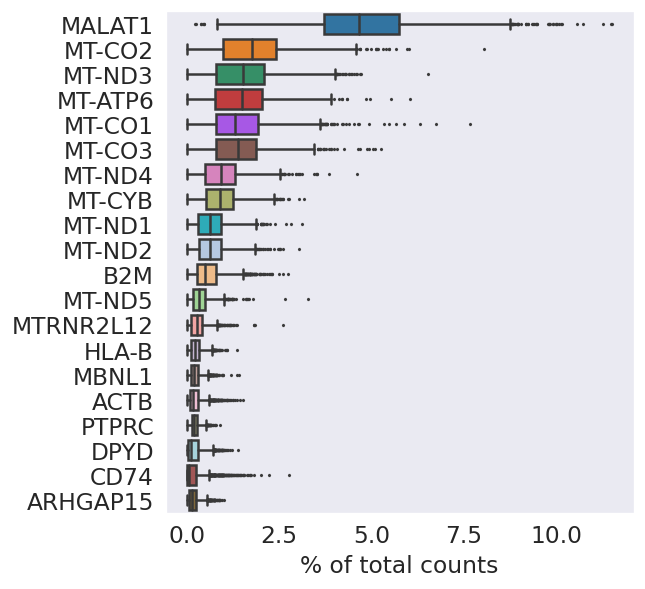

In [12]:
sc.pl.highest_expr_genes(adata, n_top=20)


In [13]:
expressed_genes = np.sum(adata.X > 0, 1)
adata.obs['n_genes'] = expressed_genes
len(expressed_genes)


2885

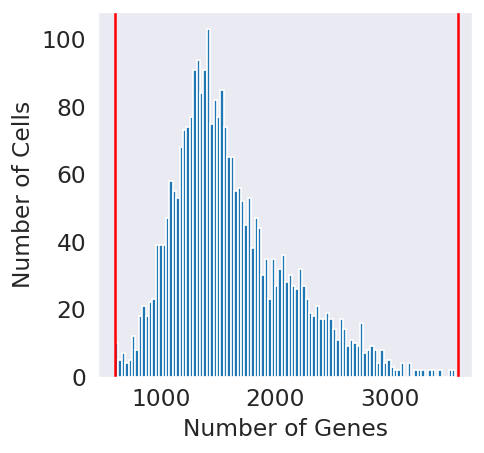

In [14]:
n, bins, *x = plt.hist(expressed_genes, bins=100)
plt.axvline(600, c="r")
plt.axvline(3600, c="r")
plt.xlabel("Number of Genes")
plt.ylabel("Number of Cells")
plt.show()

In [15]:
sc.pp.filter_cells(adata, min_genes=600)
sc.pp.filter_cells(adata, max_genes=3600)


In [16]:
mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)


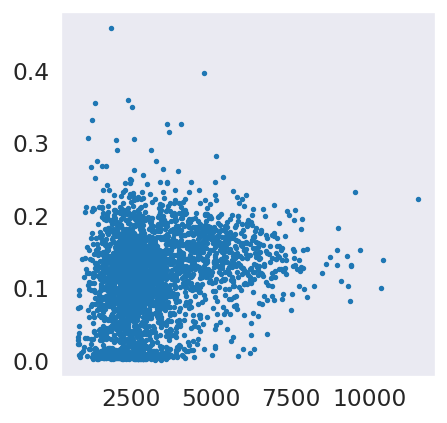

In [17]:
plt.scatter(adata.obs["n_counts"], adata.obs["percent_mito"], s=5)
plt.show()

In [18]:
adata_raw = adata.copy()
adata.raw = adata_raw

In [19]:
sc.pp.filter_genes(adata, min_cells=20)
adata

AnnData object with n_obs × n_vars = 2885 × 14074
    obs: 'n_counts', 'n_genes', 'percent_mito', 'cell_type'
    var: 'feature_types', 'gene_ids', 'n_cells'
    uns: 'cell_type_colors', 'mode2_var_chr', 'mode2_var_end', 'mode2_var_start', 'release', 'species'
    obsm: 'X_umap', 'mode2'

In [20]:
sc.pp.normalize_total(adata)

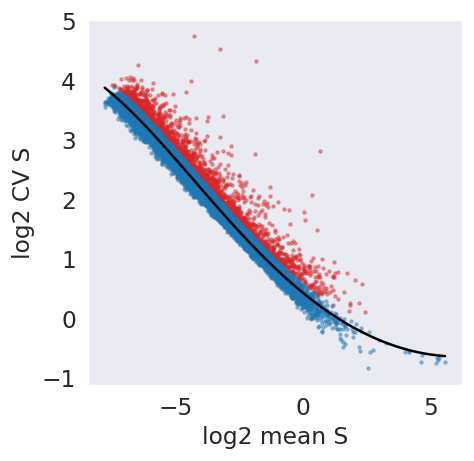

In [21]:
cv_vs_mean_keep = filter_cv_vs_mean(adata.X.toarray().T, N=2000, max_expr_avg=50)


In [22]:
sc.pp.log1p(adata)


In [23]:
adata = adata[:, cv_vs_mean_keep].copy()

In [24]:
sc.pp.scale(adata, max_value=10)


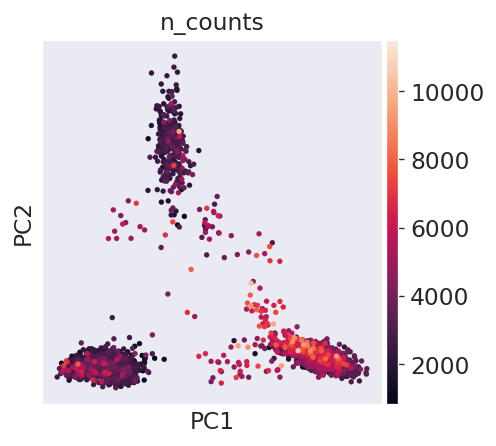

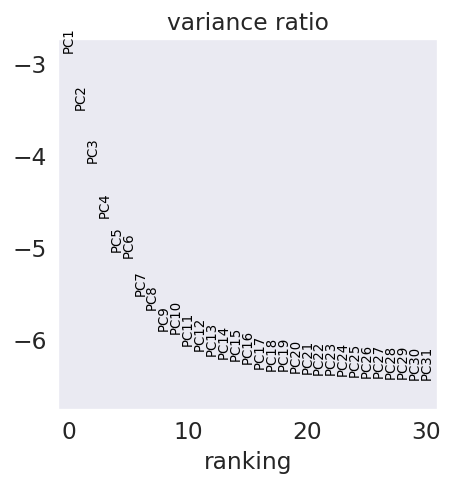

In [25]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='n_counts')
sc.pl.pca_variance_ratio(adata, log=True)


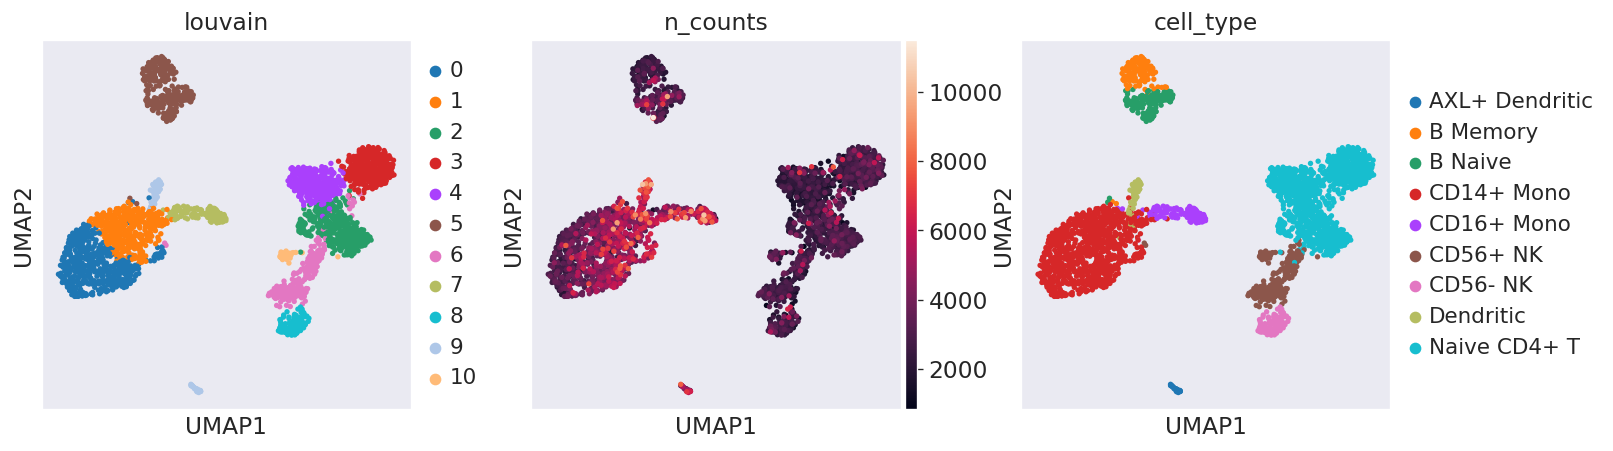

In [26]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=20)
sc.tl.umap(adata, alpha=0.3, min_dist=.5)
sc.tl.louvain(adata, resolution=1)
sc.pl.umap(adata, use_raw=False, color=["louvain", "n_counts", "cell_type"], ncols=5)

In [27]:
#sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon', n_genes=20, use_raw=True)


In [28]:
#sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon', use_raw=True)


In [29]:
#pd.DataFrame(adata.uns["rank_genes_groups"]["names"])


In [30]:
adata.shape


(2885, 2001)

In [31]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=20 )
#idx = np.random.permutation(adata.obsm['X_pca'].shape[0])
#adata.obsm['X_pca'] = adata.obsm['X_pca'][idx,:]
#adata.obsm['Suffle_idx']=idx
RNA_struct=adata
RNA_data=adata.obsm['X_pca']
RNA_data.shape

(2885, 20)

**RNA_Raw**

In [32]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon', use_raw=True)

In [33]:
pd.DataFrame(adata.uns["rank_genes_groups"]["names"])

,0,1,2,3,4,5,6,7,8,9,10
0,VCAN,LYZ,INPP4B,LEF1,FHIT,BANK1,CCL5,TCF7L2,GNLY,AFF3,SLC4A10
1,DPYD,TYMP,ANK3,THEMIS,LEF1,AFF3,NKG7,MTSS1,PRF1,CD74,A2M
2,PLXDC2,PSAP,LTB,NELL2,BCL11B,RALGPS2,A2M,FCGR3A,NKG7,GRN,ZBTB16
3,ARHGAP26,AOAH,SYNE2,BACH2,CAMK4,MS4A1,SYNE2,LST1,MCTP2,RUNX2,IL7R
4,CSF3R,FCN1,ARHGAP15,PDE3B,ANK3,PAX5,IL32,IFITM3,CD247,HDAC9,RORA
...,...,...,...,...,...,...,...,...,...,...,...
36596,RPL3,PRKCH,MARCH1,UTRN,MYO1F,SAMHD1,CD74,BACH2,SIPA1L1,TC2N,POU2F2
36597,RPL41,CD247,ARHGAP26,MYO1F,LYN,AAK1,HLA-DRA,BCL11B,STK17B,CD247,GNAQ
36598,RPS27A,BACH2,LYN,KLF6,CD74,AOAH,GNAQ,PARP8,GNAQ,CAMK4,DOCK8
36599,RPS2,BCL11B,ZEB2,LYN,PRKCB,DPYD,LYN,PRKCH,MAML2,BCL11B,FOXP1


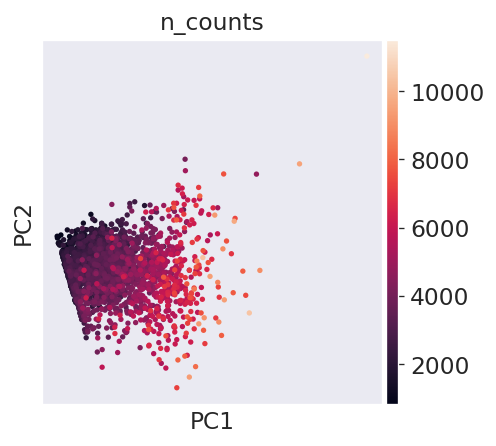

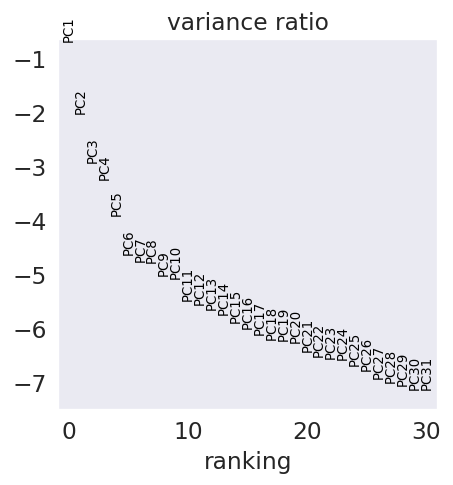

In [34]:
sc.tl.pca(adata_raw, svd_solver='arpack')
sc.pl.pca(adata_raw, color='n_counts')
sc.pl.pca_variance_ratio(adata_raw, log=True)

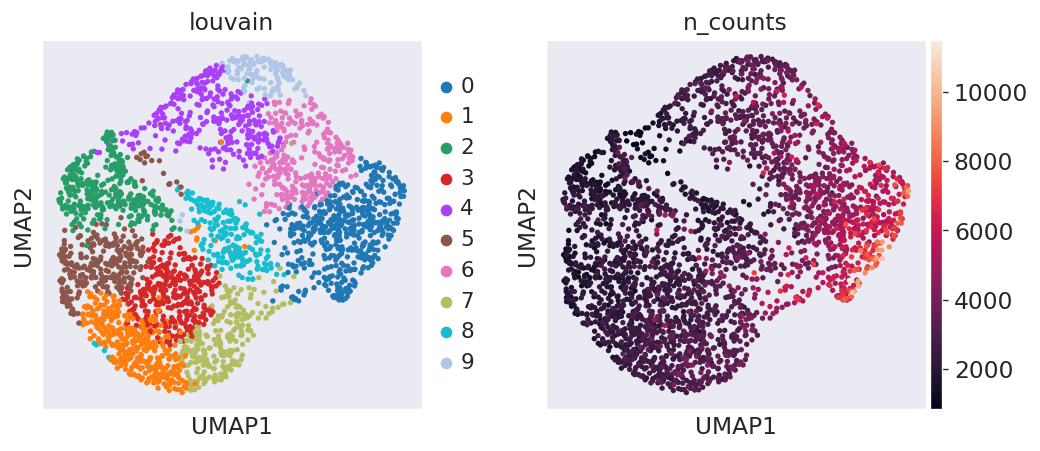

In [35]:
sc.pp.neighbors(adata_raw, n_neighbors=30, n_pcs=30)
sc.tl.umap(adata_raw, alpha=0.3, min_dist=.5)
sc.tl.louvain(adata_raw, resolution=1)
sc.pl.umap(adata_raw, color=["louvain", "n_counts"], ncols=5)

In [36]:
RNA_struct_raw=adata_raw

**ATAC**

In [37]:
# Replace RNA with ATAC counts!
peaks = adata.uns["mode2_var_chr"]+":"+adata.uns["mode2_var_start"]+"-"+adata.uns["mode2_var_end"]
cells = adata.obs.index
adata = sc.AnnData(adata.obsm["mode2"])
adata.var.index = peaks
adata.obs.index = cells
adata


AnnData object with n_obs × n_vars = 2885 × 77242

In [38]:
adata.obs['n_counts'] = adata.X.toarray().sum(axis=1)
print(np.mean(adata.obs['n_counts']))
print(np.std(adata.obs['n_counts'])), 
print(2.5*int(np.std(adata.obs['n_counts'])) + int(np.mean(adata.obs['n_counts'])))


12450.734375
7575.0888671875
31387.5


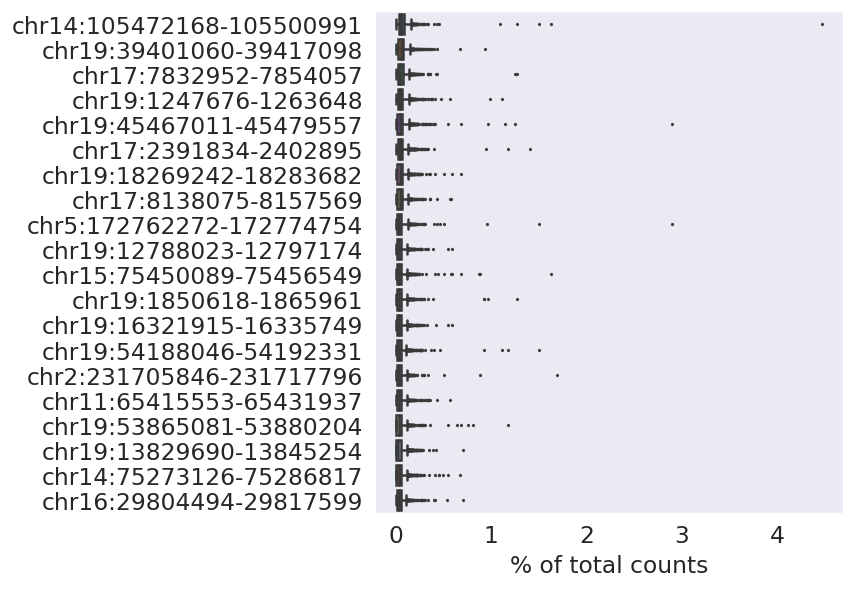

In [39]:
sc.pl.highest_expr_genes(adata, n_top=20)


In [40]:
expressed_genes = np.sum(adata.X.toarray() > 0, 1)
adata.obs['n_genes'] = expressed_genes
len(expressed_genes)


2885

In [41]:
adata_raw = adata.copy()


In [42]:
sc.pp.filter_genes(adata, min_cells=50)
adata

AnnData object with n_obs × n_vars = 2885 × 43860
    obs: 'n_counts', 'n_genes'
    var: 'n_cells'

In [43]:
sc.pp.normalize_total(adata)


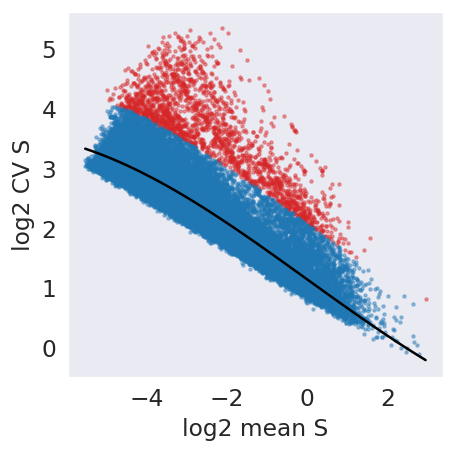

In [44]:
cv_vs_mean_keep = filter_cv_vs_mean(adata.X.toarray().T, N=2000, max_expr_avg=50)


In [45]:
sc.pp.log1p(adata)


In [46]:
adata = adata[:, cv_vs_mean_keep].copy()


In [47]:
sc.pp.scale(adata, max_value=10)


In [48]:
adata

AnnData object with n_obs × n_vars = 2885 × 2001
    obs: 'n_counts', 'n_genes'
    var: 'n_cells', 'mean', 'std'
    uns: 'log1p'

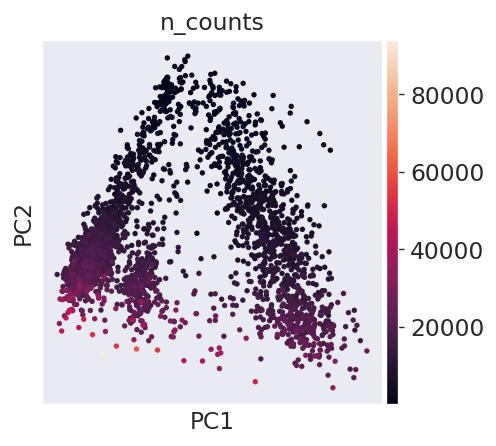

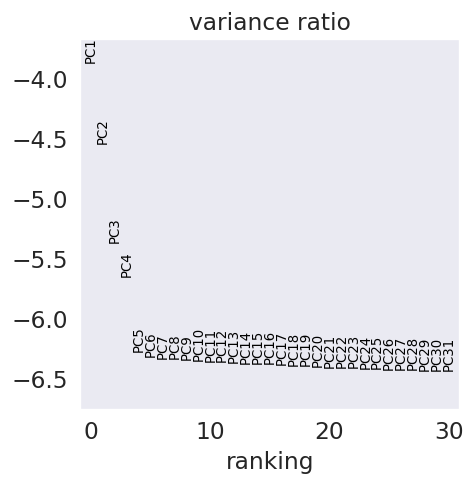

In [49]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='n_counts')
sc.pl.pca_variance_ratio(adata, log=True)


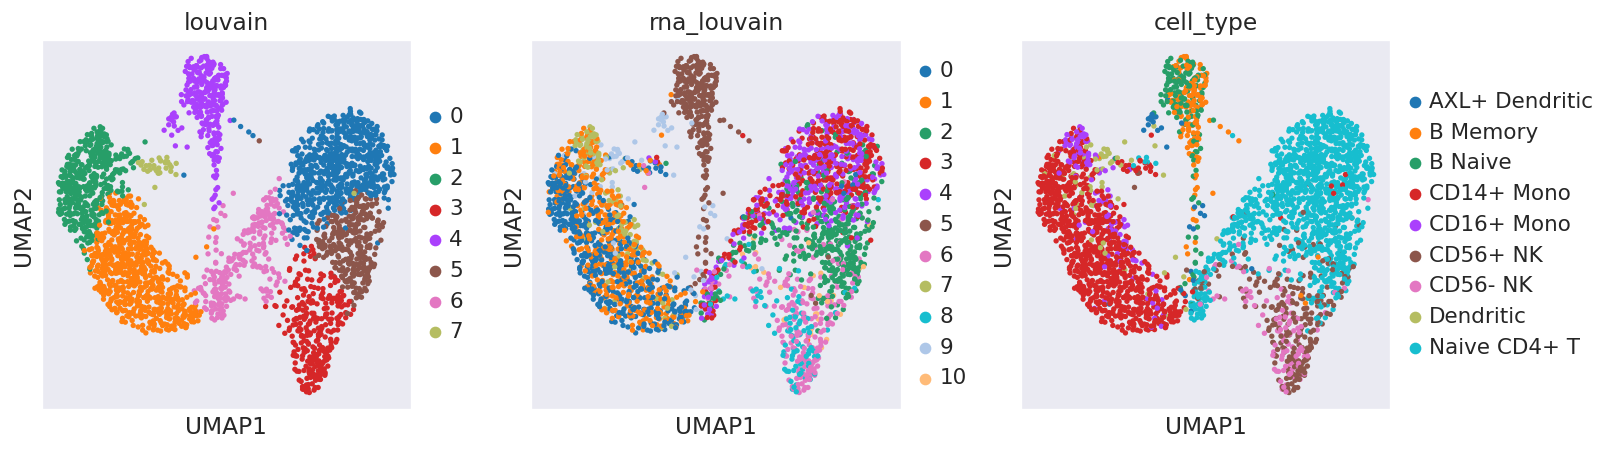

In [50]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=10)
sc.tl.umap(adata, alpha=0.3, min_dist=.5)
sc.tl.louvain(adata, resolution=1)
adata.obs["rna_louvain"] = RNA_struct.obs["louvain"]
adata.obs["cell_type"] = RNA_struct.obs["cell_type"]
sc.pl.umap(adata, use_raw=False, color=["louvain", "rna_louvain", "cell_type"], ncols=5)
RNA_struct.obs["atac_louvain"] = np.array(adata.obs["louvain"])

In [51]:
#from sklearn.decomposition import LatentDirichletAllocation
#X = adata.X
#rng=np.random.RandomState(0)
#lda = LatentDirichletAllocation(random_state=rng)
#lda.fit(X)
#LatentDirichletAllocation(...)
#lda.transform(X[-2:])

In [52]:
#sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon', n_genes=20, use_raw=True)


In [53]:
#pd.DataFrame(adata.uns["rank_genes_groups"]["names"])


In [54]:
adata.shape


(2885, 2001)

In [55]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=10 )
#idx = np.random.permutation(adata.obsm['X_pca'].shape[0])
#adata.obsm['X_pca'] = adata.obsm['X_pca'][idx,:]
#adata.obsm['Suffle_idx']=idx
ATAC_struct=adata
ATAC_data=adata.obsm['X_pca']
ATAC_data.shape

(2885, 10)

In [56]:
ATAC_struct

AnnData object with n_obs × n_vars = 2885 × 2001
    obs: 'n_counts', 'n_genes', 'louvain', 'rna_louvain', 'cell_type'
    var: 'n_cells', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'louvain', 'louvain_colors', 'rna_louvain_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

**ATAC_raw**

In [57]:
#sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon', n_genes=20, use_raw=True)

In [58]:
#pd.DataFrame(adata.uns["rank_genes_groups"]["names"])

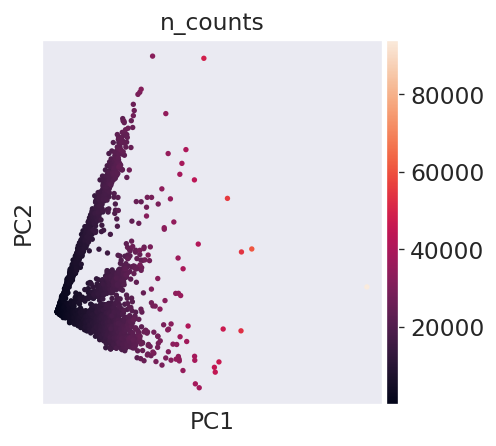

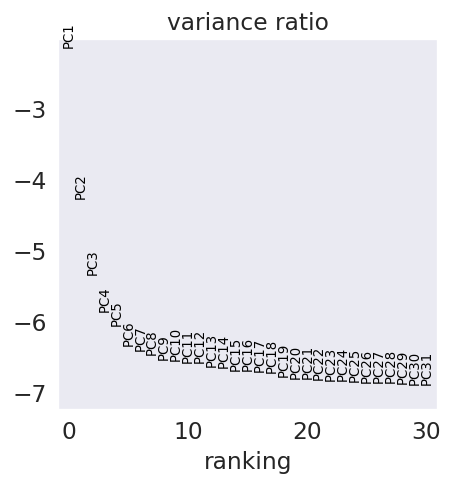

In [59]:
sc.tl.pca(adata_raw, svd_solver='arpack')
sc.pl.pca(adata_raw, color='n_counts')
sc.pl.pca_variance_ratio(adata_raw, log=True)

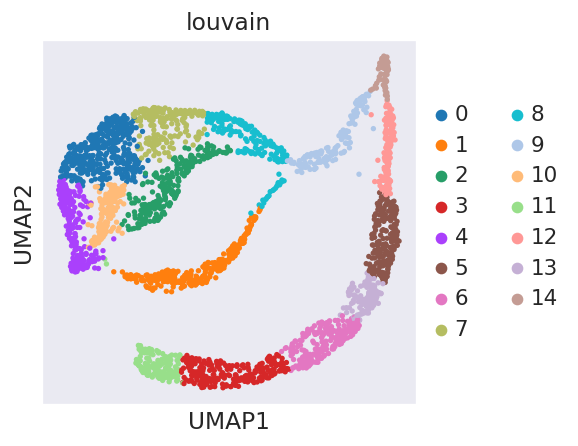

In [60]:
sc.pp.neighbors(adata_raw, n_neighbors=30, n_pcs=16)
sc.tl.umap(adata_raw, alpha=0.3, min_dist=.5)
sc.tl.louvain(adata_raw, resolution=1)
sc.pl.umap(adata_raw, color=["louvain"], ncols=5)

In [61]:
ATAC_struct_raw=adata_raw

In [62]:
ATAC_struct

AnnData object with n_obs × n_vars = 2885 × 2001
    obs: 'n_counts', 'n_genes', 'louvain', 'rna_louvain', 'cell_type'
    var: 'n_cells', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'louvain', 'louvain_colors', 'rna_louvain_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [63]:
ATAC_struct_raw

AnnData object with n_obs × n_vars = 2885 × 77242
    obs: 'n_counts', 'n_genes', 'louvain'
    uns: 'pca', 'neighbors', 'umap', 'louvain', 'louvain_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [64]:
RNA_struct

AnnData object with n_obs × n_vars = 2885 × 2001
    obs: 'n_counts', 'n_genes', 'percent_mito', 'cell_type', 'louvain', 'atac_louvain'
    var: 'feature_types', 'gene_ids', 'n_cells', 'mean', 'std'
    uns: 'cell_type_colors', 'mode2_var_chr', 'mode2_var_end', 'mode2_var_start', 'release', 'species', 'log1p', 'pca', 'neighbors', 'umap', 'louvain', 'louvain_colors', 'rank_genes_groups'
    obsm: 'X_umap', 'mode2', 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [65]:
RNA_struct_raw

AnnData object with n_obs × n_vars = 2885 × 36601
    obs: 'n_counts', 'n_genes', 'percent_mito', 'cell_type', 'louvain'
    var: 'feature_types', 'gene_ids'
    uns: 'cell_type_colors', 'mode2_var_chr', 'mode2_var_end', 'mode2_var_start', 'release', 'species', 'pca', 'neighbors', 'umap', 'louvain', 'louvain_colors'
    obsm: 'X_umap', 'mode2', 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [66]:
RNA_struct.write("FastPy_PBMC_RNA_struct_2000.h5ad")

/home/zmoslehi/miniconda3/envs/PBMC/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'atac_louvain' as categorical


In [67]:
RNA_struct_raw.write("FastPy_PBMC_RNA_struct_raw.h5ad")

In [68]:
ATAC_struct.write("FastPy_PBMC_ATAC_struct_2000.h5ad")

In [69]:
ATAC_struct_raw.write("FastPy_PBMC_ATAC_struct_raw.h5ad")